# mIns MRS_Voxel-to-Voxel

## Make a mask
===============

The Seed-to-Voxel connectivities from healty controls are averaged and thresholded to 0.2 (corresponding approssimately to p = 0.01), giving the ROI

## Extract connectivities
=========================

After applyng the mask to every connectivity mask (CONN's files with BETA prefix), the connectivities of every grey matter voxel are summed giving the connectivity value for the individual subject.

Ref: ToDo


Prefixes:
=========
-) BETA_ nii the BETA files contain the Fisher transformed coefficients ( z=atanh(r) ). When the Analyses.measure is set to 3 (regression) or 4 (multivariate regression), then the BETA files contain the regression coefficients (beta values) and the corr files should be disregarded (they actually contain tanh(beta) but these are not particularly meaningful measures). 

-) corr_ nii When the Analyses.measure field is set to 1 (bivariate correlation) or 2 (semi-partial correlation) the corr fles contain the correlation coefficients (r) (or semi-partial correlation coefficients when Analyses.measure is set to 2)..... corr_* files are only generated if you select the corresponding option in the Setup->Options tab ('Create first-level seed-to-voxel r-maps').

-) p_corr nii the p_corr and pFDR images simply contain the uncorrected and FDR-corrected p-values, respectively

-) pFDR nii the p_corr and pFDR images simply contain the uncorrected and FDR-corrected p-values, respectively

-) resultsROI mat

-) se nii
-) 

## Sources

In [1]:
import glob
import nibabel as nib
import pandas as pd
import seaborn as sns
import nilearn
from nilearn import plotting
from nilearn import image
import numpy as np
from scipy.io import loadmat
from scipy import stats

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
mat = loadmat('/media/2Tb/functional_analysis_jan2021/NeuroMet_fmriprep_conn/results/firstlevel/MRS_Voxel_to_Voxel/_list_sources.mat')

In [3]:
mat['sourcenames']

array([[array(['MRS_Voxel'], dtype='<U9')]], dtype=object)

In [4]:
# MRS Voxel is source 6

In [5]:
# Grab all MRS-Voxel-to-whole-Brain connectivity maps niftis
s1_beta_path = glob.glob('/media/2Tb/functional_analysis_jan2021/NeuroMet_fmriprep_conn/results/firstlevel/MRS_Voxel_to_Voxel/BETA_Subject*_Condition001_Source001.nii')
len(s1_beta_path)

95

In [6]:
subnumber = len(s1_beta_path)

In [7]:
# sort them
s1_beta_path = sorted(s1_beta_path, key=(lambda x: x.split('_')[-3][-3:]))

In [8]:
# Load Subjects' data

In [95]:
cov_path = '/media/drive_s/AG/AG-Floeel-Imaging/02-User/NEUROMET/Functional_analysis/mIns_fMRI/conn_covs_20200115.csv'
data = pd.read_csv(cov_path)

In [96]:
data['BETA_path'] = s1_beta_path

In [97]:
data.head()

,CONN_ID,ID,diag,QC,BETA_path
0,1,sub-NeuroMET003,2.0,G,/media/2Tb/functional_analysis_jan2021/NeuroMe...
1,2,sub-NeuroMET004,0.0,G,/media/2Tb/functional_analysis_jan2021/NeuroMe...
2,3,sub-NeuroMET006,0.0,G,/media/2Tb/functional_analysis_jan2021/NeuroMe...
3,4,sub-NeuroMET007,1.0,G,/media/2Tb/functional_analysis_jan2021/NeuroMe...
4,5,sub-NeuroMET008,0.0,G,/media/2Tb/functional_analysis_jan2021/NeuroMe...


In [98]:
len(data)

95

In [99]:
data_qc = data[(data.QC == 'G') | (data.QC == 'Y')]

In [100]:
data_qc['index'] = data_qc.index

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [101]:
# the diag2 == 1 are the healty controls, we have to take the subject numbers for them

In [102]:
hc_pos = data_qc[(data_qc.diag == 0)]['index'].values

In [103]:
len(data_qc)

86

In [104]:
data_qc.BETA_path[0]

'/media/2Tb/functional_analysis_jan2021/NeuroMet_fmriprep_conn/results/firstlevel/MRS_Voxel_to_Voxel/BETA_Subject001_Condition001_Source001.nii'

In [105]:
%%time
# Summing the HC connectivity masks
avg_mask = nib.load(data_qc.BETA_path[list(hc_pos)[0]]).get_fdata()

for subnum in list(hc_pos)[1:]: 
    conn_map = nib.load(data_qc.BETA_path[subnum]).get_fdata() # Load connectivities as numpy array
    avg_mask += conn_map

CPU times: user 3.87 s, sys: 395 ms, total: 4.27 s
Wall time: 801 ms


In [106]:
avg_mask.shape

(193, 229, 193)

In [107]:
# average
avg_mask = avg_mask / len(hc_pos)

In [108]:
# thresholding
threshold = 0.3 # corresponding p<0.01 for our sample size
avg_mask = np.where(avg_mask>threshold,1,0)

In [109]:
# Making nii
example_img = nib.load(s1_beta_path[list(hc_pos)[0]])
mask_nii = nib.Nifti1Image(avg_mask, example_img.affine, header=example_img.header)

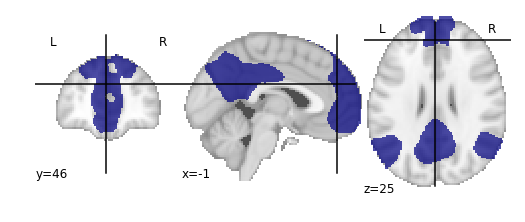

In [110]:
plotting.plot_roi(mask_nii)

In [111]:
# Save mask as NifTi
nib.save(mask_nii, 'mIns_avg_Mask_thres_03_HC.nii.gz')

In [112]:
# Apply mask to every subject and then average to have the connectivities

In [113]:
mask_voxels = avg_mask.sum()

In [114]:
%%time
mean_conn = list()
for beta in data.BETA_path:
    try:
        img = nib.load(beta).get_fdata()
        masked_img = np.where(avg_mask,img,0)
        mean_conn.append(masked_img.sum()/mask_voxels)
    except:
        mean_conn.append(0)

CPU times: user 2.69 s, sys: 2.93 s, total: 5.62 s
Wall time: 5.62 s


In [115]:
len(mean_conn)

95

In [116]:
len(data.diag.values)

95

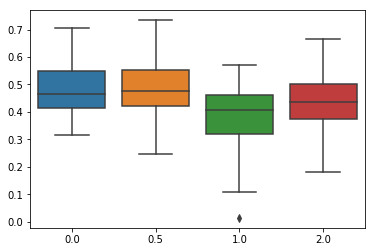

In [117]:
sns.boxplot(y=mean_conn, x=data.diag.values)

In [118]:
masked_img_nii = nib.Nifti1Image(masked_img, example_img.affine, header=example_img.header)

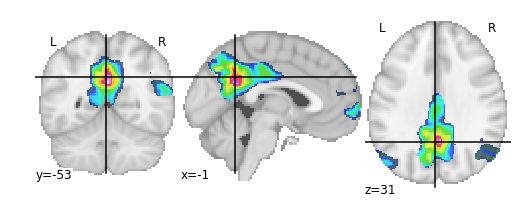

In [119]:
plotting.plot_roi(masked_img_nii)

In [120]:
data['mean_conn'] = mean_conn

In [121]:
data.to_csv('conns.csv')